In [52]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8439938566321932410
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13409278822903456099
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [53]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2):
    return compare_ssim(img1, img2)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [54]:
"""
    basic CNN model
"""
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

In [55]:
"""
    load validation data
"""
import gc

dataY = np.zeros((80,512, 512))

for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    dataY[i-1] = img
    
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [56]:
"""
    noise 50%
"""
X_50 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise50.png", cv2.IMREAD_GRAYSCALE)
    X_50[i-1] = img

X_50 = X_50.reshape(-1, 512, 512, 1)
X_50 = X_50.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_50 ==
loss: 0.004841915518045426
accuracy: 0.0


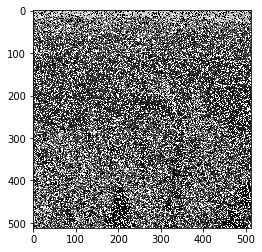

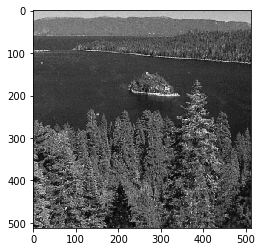

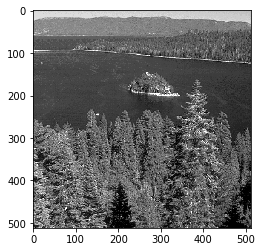

26.314575672149658
27.74539503455162
0.8934406978213979
0.8814061656438875


True

In [57]:
model = SRCNN("SRCNN_500099.h5")
print("== SRCNN_50 ==")
X_50 = X_50.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_50, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_50)
result = result.reshape(-1, 512, 512)
X_50 = X_50.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_50[7]
plt.imshow(img, cmap="gray")
plt.show()

img = result[7]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[7]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[7], result[7]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
#print(totalPSNR)
print(totalPSNR / 80)
totalSSIM = 0
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
#print(totalSSIM)
print(SSIM(dataY[7], result[7]))
print(totalSSIM / 80)

img = result[12]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/13_denoise50.png", img)
img = result[79]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/80_denoise50.png", img)

In [58]:
"""
    noise 60%
"""
X_60 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise60.png", cv2.IMREAD_GRAYSCALE)
    X_60[i-1] = img

X_60 = X_60.reshape(-1, 512, 512, 1)
X_60 = X_60.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_60 ==
loss: 0.006782168429344893
accuracy: 0.0


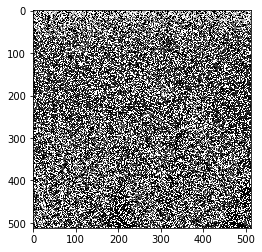

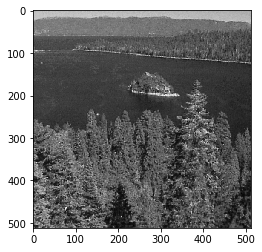

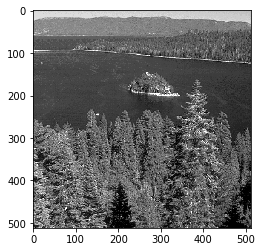

25.11185884475708
26.358930177986622
0.8584569338962246
0.850875641270593


True

In [59]:
model = SRCNN("SRCNN_600099.h5")
print("== SRCNN_60 ==")
X_60 = X_60.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_60, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_60)
result = result.reshape(-1, 512, 512)
X_60 = X_60.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_60[7]
plt.imshow(img, cmap="gray")
plt.show()

img = result[7]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[7]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[7], result[7]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
#print(totalPSNR)
print(totalPSNR / 80)
totalSSIM = 0
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
#print(totalSSIM)
print(SSIM(dataY[7], result[7]))
print(totalSSIM / 80)

img = result[12]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/13_denoise60.png", img)
img = result[79]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/80_denoise60.png", img)

In [60]:
"""
    noise 70%
"""
X_70 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise70.png", cv2.IMREAD_GRAYSCALE)
    X_70[i-1] = img

X_70 = X_70.reshape(-1, 512, 512, 1)
X_70 = X_70.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_70 ==
loss: 0.00830308124423027
accuracy: 0.0


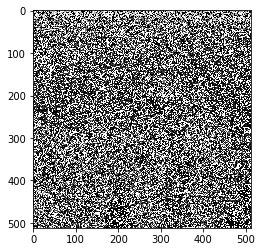

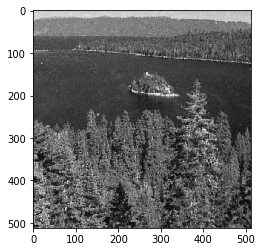

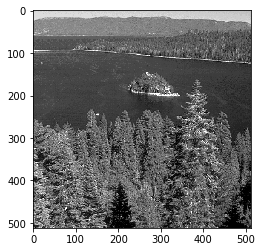

23.082940578460693
24.525280982255936
0.7897118586398162
0.8031302079344858


True

In [61]:
model = SRCNN("SRCNN_700095.h5")
print("== SRCNN_70 ==")
X_70 = X_70.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_70, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_70)
result = result.reshape(-1, 512, 512)
X_70 = X_70.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_70[7]
plt.imshow(img, cmap="gray")
plt.show()

img = result[7]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[7]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[7], result[7]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
#print(totalPSNR)
print(totalPSNR / 80)
totalSSIM = 0
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
#print(totalSSIM)
print(SSIM(dataY[7], result[7]))
print(totalSSIM / 80)


img = result[12]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/13_denoise70.png", img)
img = result[79]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/80_denoise70.png", img)

In [62]:
"""
    noise 80%
"""
X_80 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise80.png", cv2.IMREAD_GRAYSCALE)
    X_80[i-1] = img

X_80 = X_80.reshape(-1, 512, 512, 1)
X_80 = X_80.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_80 ==
loss: 0.010538082383573056
accuracy: 0.0


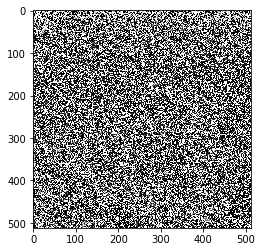

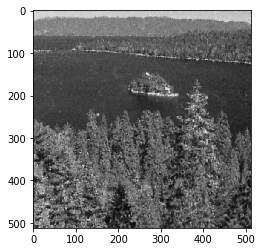

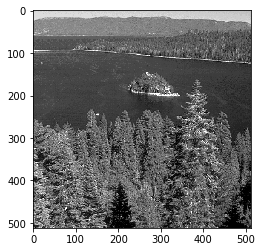

22.172837257385254
23.47215984761715
0.7332854885871996
0.7638744545509987


True

In [63]:
model = SRCNN("SRCNN_800093.h5")
print("== SRCNN_80 ==")
X_80 = X_80.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_80, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_80)
result = result.reshape(-1, 512, 512)
X_80 = X_80.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_80[7]
plt.imshow(img, cmap="gray")
plt.show()

img = result[7]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[7]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[7], result[7]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
#print(totalPSNR)
print(totalPSNR / 80)
totalSSIM = 0
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
#print(totalSSIM)
print(SSIM(dataY[7], result[7]))
print(totalSSIM / 80)

img = result[12]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/13_denoise80.png", img)
img = result[79]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/80_denoise80.png", img)

In [64]:
"""
    noise 90%
"""
X_90 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise90.png", cv2.IMREAD_GRAYSCALE)
    X_90[i-1] = img

X_90 = X_90.reshape(-1, 512, 512, 1)
X_90 = X_90.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_90 ==
loss: 0.016033050045371054
accuracy: 0.0


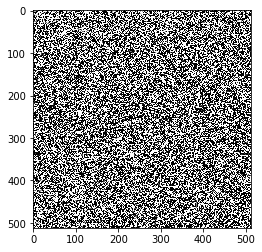

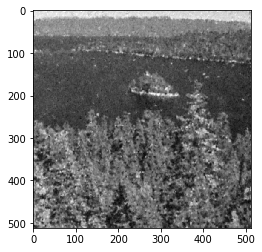

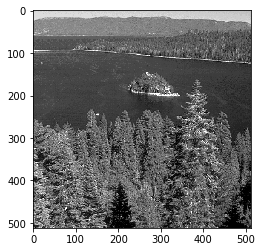

20.268826484680176
1 21.95263385772705
2 23.932528495788574
3 21.1362624168396
4 12.926571369171143
5 18.63632321357727
6 22.86660671234131
7 18.73195171356201
8 20.268826484680176
9 19.522730112075806
10 16.151673793792725
11 16.603221893310547
12 20.45173168182373
13 25.28559446334839
14 22.491469383239746
15 24.466798305511475
16 21.048400402069092
17 26.858797073364258
18 25.80955982208252
19 25.653812885284424
20 27.007908821105957
21 23.235244750976562
22 25.9928297996521
23 19.67805504798889
24 20.956134796142578
25 17.717268466949463
26 22.01655149459839
27 20.16960620880127
28 21.67133331298828
29 24.384989738464355
30 15.854384899139404
31 28.437042236328125
32 15.758674144744873
33 23.560519218444824
34 21.940863132476807
35 21.30936622619629
36 22.46112585067749
37 15.048260688781738
38 23.307645320892334
39 24.291512966156006
40 11.768049001693726
41 20.690720081329346
42 26.02877378463745
43 18.012789487838745
44 23.737642765045166
45 26.94075107574463
46 28.5832214355468

True

In [65]:
model = SRCNN("SRCNN_900095.h5")
print("== SRCNN_90 ==")
X_90 = X_90.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_90, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_90)
result = result.reshape(-1, 512, 512)
X_90 = X_90.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_90[7]
plt.imshow(img, cmap="gray")
plt.show()

img = result[7]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[7]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[7], result[7]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
    
    print(i+1, PSNR(dataY[i], result[i]))
#print(totalPSNR)
print(totalPSNR / 80)

totalSSIM = 0
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
    #img = result[i]
    #img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #cv2.imwrite("../../Denoise_80/" + str(i+1) + '.png', img)
    if SSIM(dataY[i], result[i]) > 0.7:
        print(i+1, SSIM(dataY[i], result[i]))
    
#print(totalSSIM)
print(SSIM(dataY[7], result[7]))
print(totalSSIM / 80)


img = result[12]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/13_denoise90.png", img)
img = result[79]
img = 255 * img # Now scale by 255
img = img.astype(np.uint8)
cv2.imwrite("../../target/80_denoise90.png", img)

In [66]:
print(PSNR(dataY[0], result[0]) )
print(SSIM(dataY[0], result[0]))

21.95263385772705
0.7027307208043155
